In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import matplotlib
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
trainData , info = tfds.load("fashion_mnist", split= "train", with_info=True)
testData = tfds.load("fashion_mnist", split=  "test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteQ0MJFY/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteQ0MJFY/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
classNames = ["T-shirt/Top", "Trouser/Pants", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt","Sneaker", "Bag", "Anckle boot" ]

In [ ]:
def normalization(data):
  image = data["image"]
  image = tf.reshape(image, [-1])
  image = tf.cast(image, 'float32')
  image = image / 255
  return image, data["label"]

In [ ]:
trainData = trainData.map(normalization)
testData = testData.map(normalization)

In [ ]:
batch_size = 64
train = trainData.shuffle(buffer_size = 1024).batch(batch_size)
test = testData.batch(batch_size= batch_size)

In [ ]:
def base_model():
  inputs = tf.keras.Input(shape = (784), name = "digits")
  x = tf.keras.layers.Dense(64, activation = "relu", name = "dense1")(inputs)
  x = tf.keras.layers.Dense(64, activation = "relu" , name = "dense2")(x)
  outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "pred")(x)
  model = tf.keras.Model(inputs = inputs, outputs = outputs)
  return model

In [ ]:
optimizer = tf.keras.optimizers.Adam()
sparse_cce = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
trainAccMetric = tf.keras.metrics.SparseCategoricalAccuracy()
testAccMetric = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = sparse_cce(y_true = y, y_pred = logits)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  return logits, loss_value

In [ ]:
def train_data_for_one_epoch():
  losses =[]
  #print("training on epoch Started.")
  for step, (x_batch_train, y_batch_train) in enumerate(train):
    logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)

    losses.append(loss_value)

    trainAccMetric(y_batch_train, logits)
  #print("training on epoch finished.")
  return losses

In [ ]:
def perform_validation():
  losses = []
  #print("training on val_epoch started")
  for x_val, y_val in test:
    val_logits = model(x_val)
    val_loss = sparse_cce(y_true = y_val , y_pred= val_logits)
    losses.append(val_loss)
    testAccMetric(y_val, val_logits)
  #print("training on val_epoch finished")
  return losses

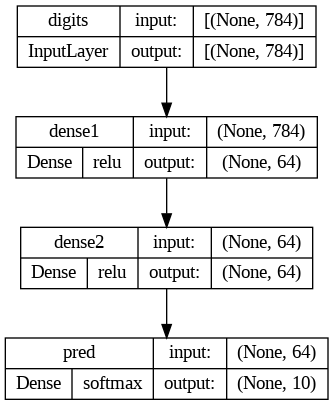

In [ ]:
model = base_model()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_activations= True)

In [ ]:
model.layers[1].weights

[<tf.Variable 'dense1/kernel:0' shape=(784, 64) dtype=float32, numpy=
 array([[-0.04561709,  0.0005179 , -0.06479885, ...,  0.00441051,
          0.05013957,  0.01359744],
        [ 0.07183314,  0.04769918,  0.01855536, ...,  0.02730516,
         -0.06538304,  0.01978029],
        [-0.06740557, -0.04807922,  0.01909664, ...,  0.0327904 ,
          0.02896722, -0.03940795],
        ...,
        [ 0.06696235, -0.01455429,  0.00600875, ..., -0.0029157 ,
          0.02582786,  0.02560939],
        [-0.06891519, -0.01732101, -0.0749539 , ..., -0.06991899,
         -0.06220235,  0.0620812 ],
        [-0.02057943,  0.04559339,  0.00615728, ..., -0.0229054 ,
         -0.02148167, -0.04537355]], dtype=float32)>,
 <tf.Variable 'dense1/bias:0' shape=(64,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:


epochs = 10
epochs_val_losses , epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' %(epoch, ))

  losses_train = train_data_for_one_epoch()
  train_acc = trainAccMetric.result()

  losses_val = perform_validation()
  test_acc = testAccMetric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: TrainLoss : %.4f ValidationLoss:%.4f, TrainAccuracy: %.4f, validationAccuracy :%.4f'
        %(epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(test_acc)))
  trainAccMetric.reset_states()
  testAccMetric.reset_states()

Start of epoch 0



 Epoch 0: TrainLoss : 0.5392 ValidationLoss:0.4535, TrainAccuracy: 0.8113, validationAccuracy :0.8413
Start of epoch 1

 Epoch 1: TrainLoss : 0.3908 ValidationLoss:0.4005, TrainAccuracy: 0.8599, validationAccuracy :0.8603
Start of epoch 2

 Epoch 2: TrainLoss : 0.3524 ValidationLoss:0.4199, TrainAccuracy: 0.8716, validationAccuracy :0.8542
Start of epoch 3

 Epoch 3: TrainLoss : 0.3291 ValidationLoss:0.3683, TrainAccuracy: 0.8799, validationAccuracy :0.8705
Start of epoch 4

 Epoch 4: TrainLoss : 0.3111 ValidationLoss:0.3542, TrainAccuracy: 0.8852, validationAccuracy :0.8733
Start of epoch 5

 Epoch 5: TrainLoss : 0.2953 ValidationLoss:0.3552, TrainAccuracy: 0.8895, validationAccuracy :0.8743
Start of epoch 6

 Epoch 6: TrainLoss : 0.2811 ValidationLoss:0.3687, TrainAccuracy: 0.8957, validationAccuracy :0.8704
Start of epoch 7

 Epoch 7: TrainLoss : 0.2728 ValidationLoss:0.3451, TrainAccuracy: 0.8982, validationAccuracy :0.8794
Start of epoch 8

 Epoch 8: TrainLoss : 0.2641 Validation